<a href="https://colab.research.google.com/github/awesomesocks123/machinelearning/blob/main/chapter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import sys
assert sys.version_info >=(3,10)

In [31]:
from packaging.version import Version
import sklearn

assert Version(sklearn.__version__) >= Version("1.6.1")

Dataset

In [32]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request


def load_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="datasets", filter="data")
  return pd.read_csv(Path("datasets/housing/housing.csv"))

housing_full = load_housing_data()

In [33]:
housing_full.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [34]:
housing_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [35]:
housing_full["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [36]:
housing_full.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


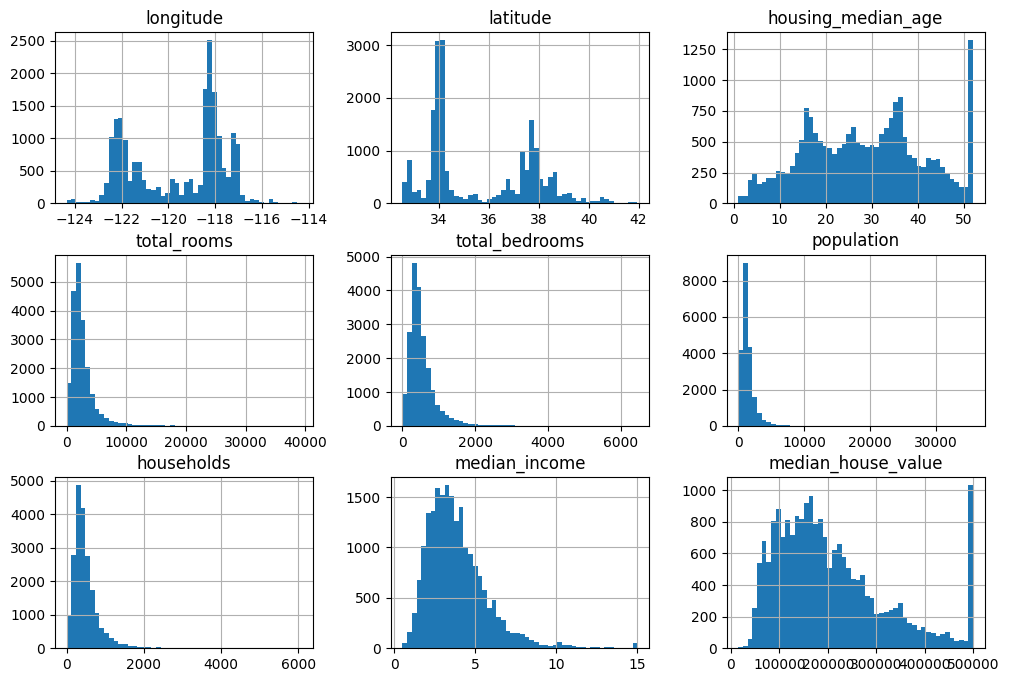

In [37]:
import matplotlib.pyplot as plt
housing_full.hist(bins=50, figsize=(12,8))
plt.show()

In [38]:
#splitting the data  80 : 20 split
#creating a test set
import numpy as np
"""
randomly shuffle data indices and split into train/test sets.

parameters:
data : dataframe or array to split
test_ratio: proportio of data that is used for testing (e.g. 0.2 for 20%)
random_state = random number genreated or seed for shuffling

returns:
train_data, test_data: two subsets split according to the test ratio

"""
def shuffle_and_split_data(data, test_ratio, random_state):
  # generate random permuation of indices
  shuffled_indicies = random_state.permutation(len(data))

  #calculate number of samples for test set
  test_set_size = int(len(data) * test_ratio)

  #first test_ratio% goes to test set, remaining to train_set
  test_indices = shuffled_indicies[:test_set_size]
  train_indicies = shuffled_indicies[test_set_size:]

  #return split data using iloc for dataFrames
  return data.iloc[train_indicies],data.iloc[test_indices]


In [39]:
random_state = np.random.default_rng() #default random number generator
train_set, test_set = shuffle_and_split_data(housing_full, 0.2, random_state)
print(len(train_set))
print(len(test_set))

16512
4128


In [40]:
"""
maintain the same testing set even to prevent the model from seeing the entire dataset
this way on each time we load the dataset the test set will remain unseen
wont be shuffled into the training set
"""

from zlib import crc32
def is_id_in_test_set(identifier, test_ratio):
  return crc32(np.int64 (identifier)) < test_ratio * 2 ** 32

def split_data_with_id_hash(data,test_ratio,id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

#since the housing dataset doesn't have an identifier column
#the simplest solution is to use the row index as the ID:

housing_with_id = housing_full.reset_index() #adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")


#incase we dont have an identifier column and data could be removed or wasn't appeneded
#to end of dataset we can use a stable column and use that as an ID

housing_with_id["id"] = (housing_full["longitude"] * 1000 + housing_full["latitude"])
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")



In [41]:
from sklearn.model_selection import train_test_split

#sklearn's own dataset splitting function behaves simlar to our shuffle_split


train_set, test_set = train_test_split(housing_full, test_size=0.2, random_state=42)


up to this point we're only using randomly sampling methods. With a large enough dataset this is fine

if the dataset is not large enough however, we will run into risks of sampling biases. we try to survey population not on just 1000 randomly selected callers but 1000 candidates that represents the whole population.

this approach is called statified sampling: the population is divied into homogeneous subgroups called strata, the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population

In [42]:
#now to prevent this biases from happening we will apply this technique to medianincome
#since median income are clustering from 1.5 - 6, there also exists values above 6
#to do this we will use panda's pd.cut to create attributes for each stratum


housing_full["income_cat"] = pd.cut(housing_full["median_income"],
                                    bins = [0.,1.5,3.0,4.5,6., np.inf],
                                    labels=[1,2,3,4,5])


<function matplotlib.pyplot.show(close=None, block=None)>

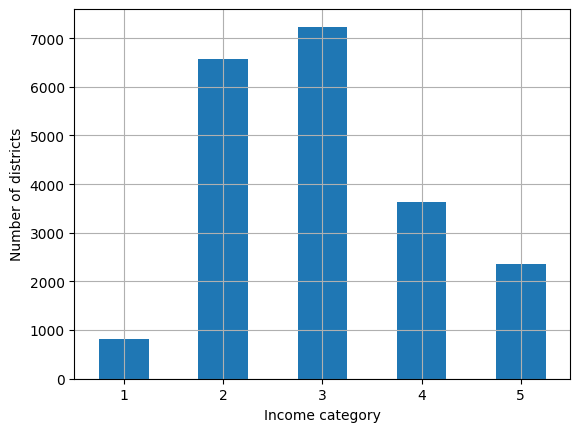

In [43]:
#now we show median income as diff categories from our previous groupings of the income clusterings
# 0 - 1.5, 1.5 - 3, etc
categories_counts = housing_full["income_cat"].value_counts().sort_index()
categories_counts.plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show

In [44]:
#stratified sampling based on income category using sklearn split()
from sklearn.model_selection import StratifiedShuffleSplit

#this generates 10 different strat splits of the same dataset
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing_full, housing_full["income_cat"]):
  strat_train_set_n = housing_full.iloc[train_index]
  strat_test_set_n = housing_full.iloc[test_index]
  strat_splits.append([strat_train_set_n, strat_test_set_n])

#we will be using the first split
strat_train_set, strat_test_set = strat_splits[0]
strat_test_set["income_cat"].value_counts()/len(strat_test_set)


,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [45]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [46]:

# this is the built in train_test_split() function using stratify so we dont have to write our own
strat_train_set, strat_test_set = train_test_split(housing_full,
                                                   test_size=0.2,
                                                   stratify=housing_full["income_cat"],
                                                   random_state=42)


In [47]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


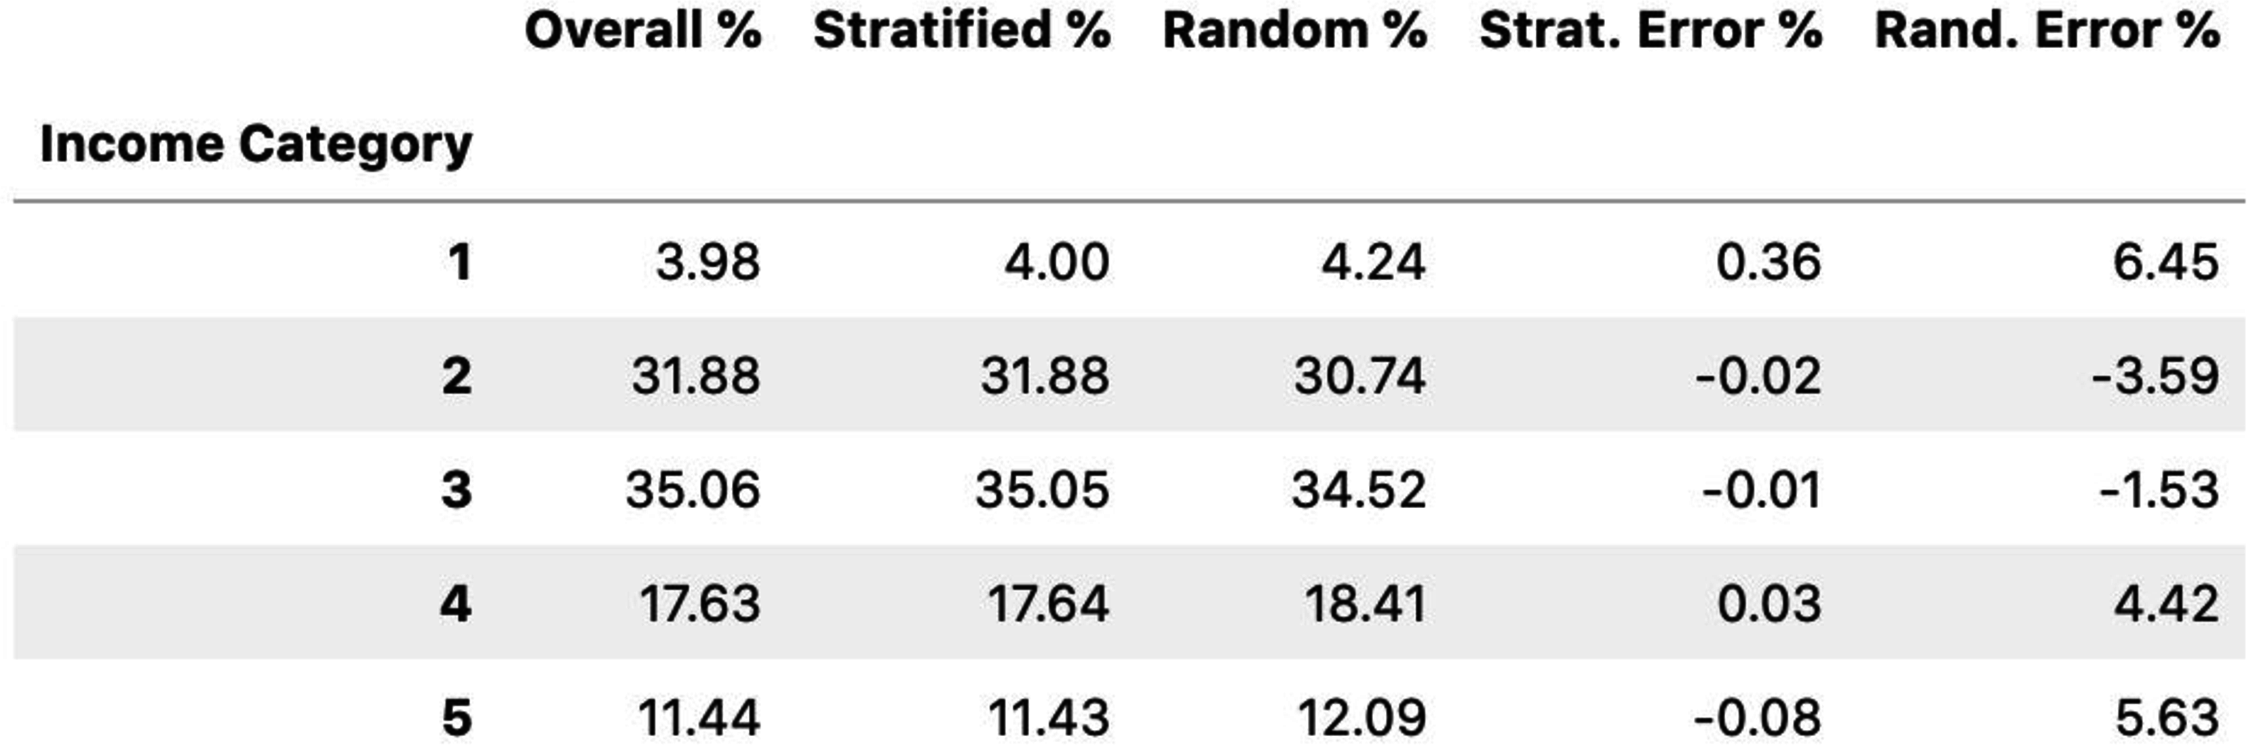

stratified splitting vs random splitting

the stratiffied error % is almost identical ot the fulldataset while the test set using purely random sampling is skewed

In [48]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

The `income_cat` column was created solely for the purpose of showing off the stratified sampling example.

It showed that the income distribution in both the training and test sets accurately reflects the overall income distribution of the dataset.

Since this column is not a feature used in the actual machine learning model, it's dropped to prevent data leakage and keep your dataset clean for modeling.

Now we begin the data exploring stage.

In [49]:
housing = strat_train_set.copy() # keeping a copy so we can revert to it afterwards

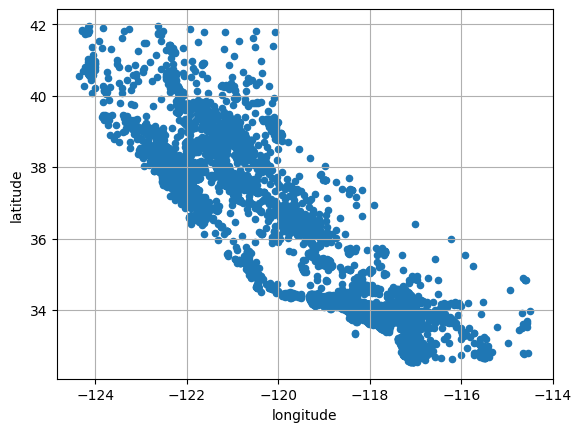

In [51]:
housing.plot(kind="scatter", x="longitude",y="latitude", grid=True)
plt.show()
#this shows us where each house is based on their lat and long
#its supposed to resemble california lol

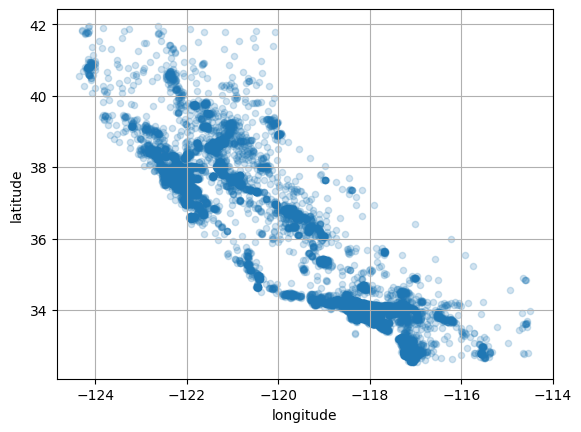

In [52]:
housing.plot(kind="scatter", x="longitude",
y="latitude", grid=True, alpha=0.2)
plt.show()
#this visualizes high density of the datapoints
#places like sf, la are heavy dotted